In [66]:
%load_ext autoreload
%autoreload 2

import numpy as np; np.set_printoptions(precision=4); np.random.seed(0)
import torch; torch.set_printoptions(precision=4)
seed = 1

torch.manual_seed(seed)
import torch.nn as nn
import matplotlib.pyplot as plt; plt.rc('font', size=12)
import matplotlib 
from matplotlib.font_manager import FontProperties
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
import seaborn as sns
import time
import sys
import itertools
import random; random.seed(0)
import scipy
import os
from textwrap import wrap
from scipy.stats import wilcoxon

sys.path.append("../two_module_rnn/code")
os.chdir('/home/yl4317/Documents/two_module_rnn/code')
from functions import *
# os.chdir('/home/yl4317/Documents/two_module_rnn/')

print(torch.__version__)
print(sys.version)
                
%matplotlib inline

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True) 
torch.backends.cudnn.deterministic = True    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.13.1+cu116
3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


# Supplementary figure 1 - single cell traces

/home/yl4317/Documents/two_module_rnn/code/functions.py:2587: RuntimeWarning: invalid value encountered in divide
  rule_sel_across_time[n] = (act_rule1_time - act_rule2_time)/(np.abs(act_rule1_time) + np.abs(act_rule2_time))
/home/yl4317/Documents/two_module_rnn/code/functions.py:2597: RuntimeWarning: invalid value encountered in scalar divide
  rule_sel_fdbk = (act_rule1_fdbk - act_rule2_fdbk)/(np.abs(act_rule1_fdbk) + np.abs(act_rule2_fdbk))
/home/yl4317/Documents/two_module_rnn/code/functions.py:2601: RuntimeWarning: invalid value encountered in scalar divide
  rule_sel_iti = (act_rule1_iti - act_rule2_iti)/(np.abs(act_rule1_iti) + np.abs(act_rule2_iti))
/home/yl4317/Documents/two_module_rnn/code/functions.py:2605: RuntimeWarning: invalid value encountered in scalar divide
  rule_sel_ref_card = (act_rule1_ref_card - act_rule2_ref_card)/(np.abs(act_rule1_ref_card) + np.abs(act_rule2_ref_card))
/home/yl4317/Documents/two_module_rnn/code/functions.py:2609: RuntimeWarning: invalid valu

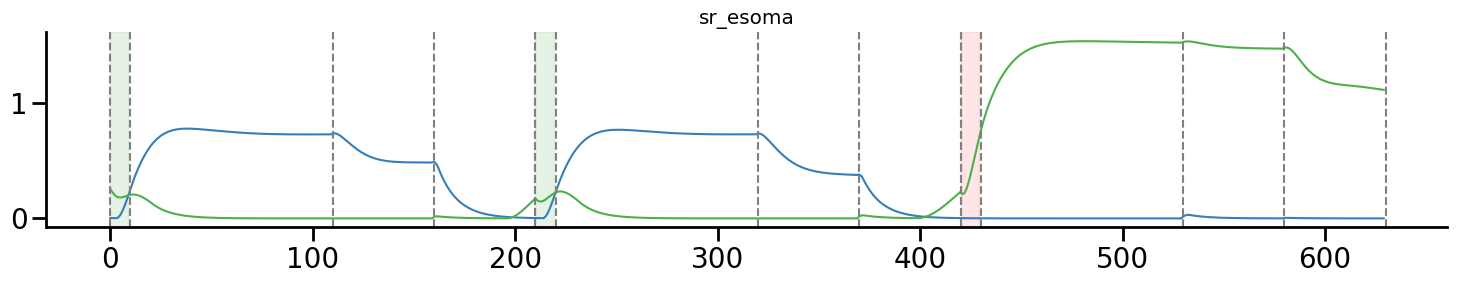

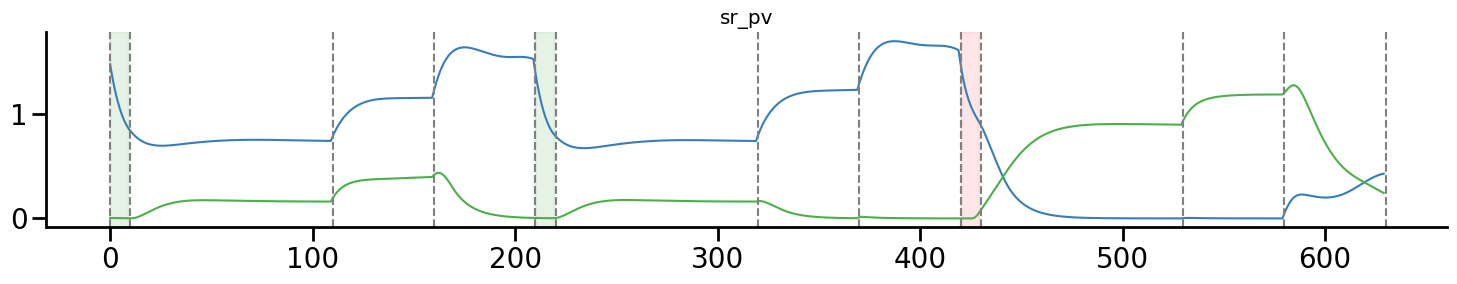

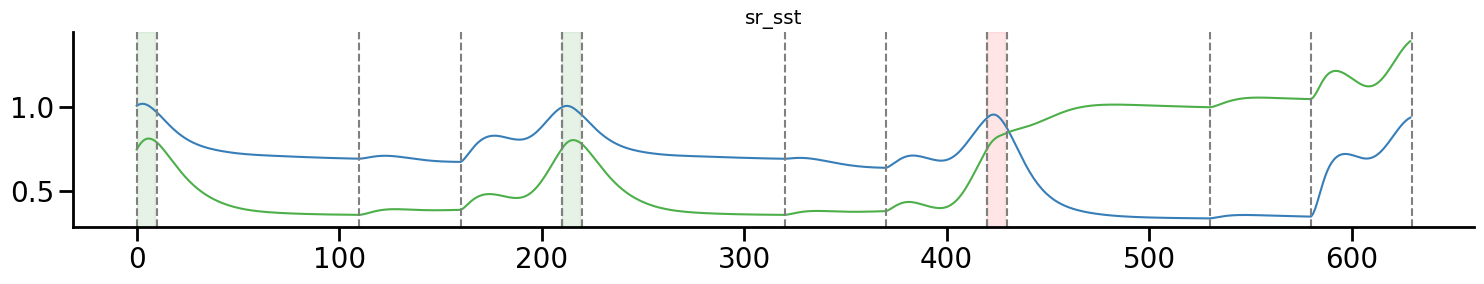

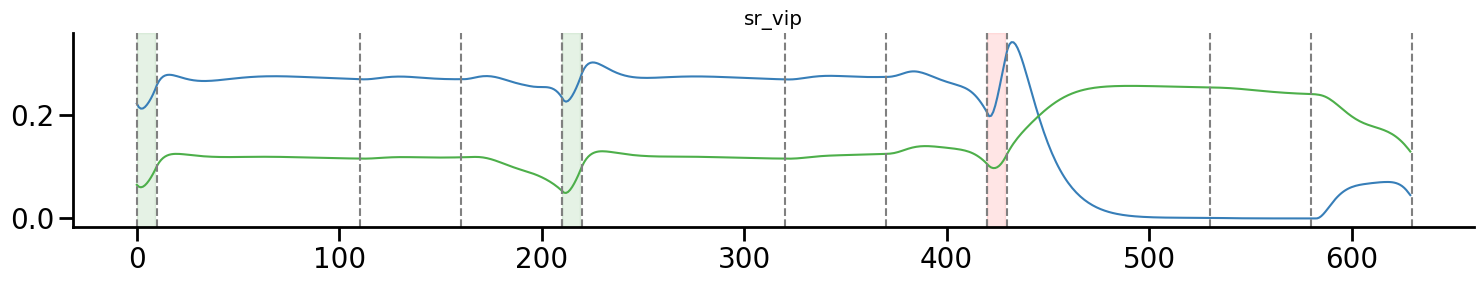

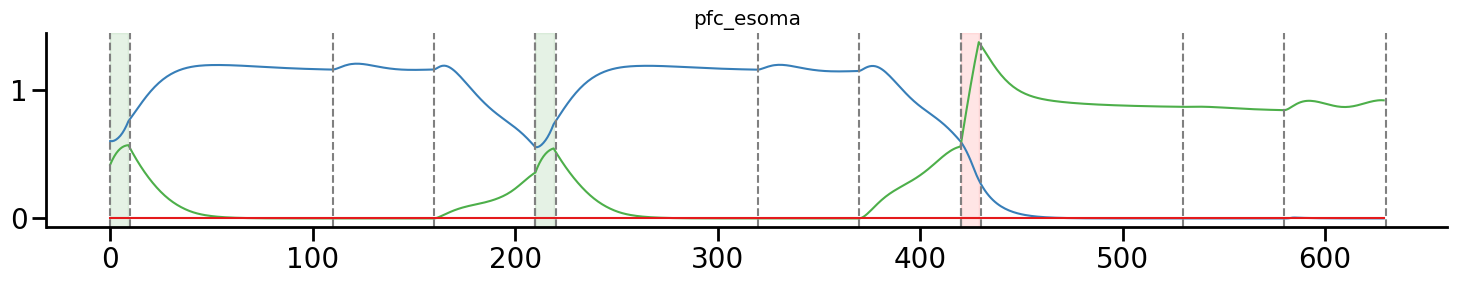

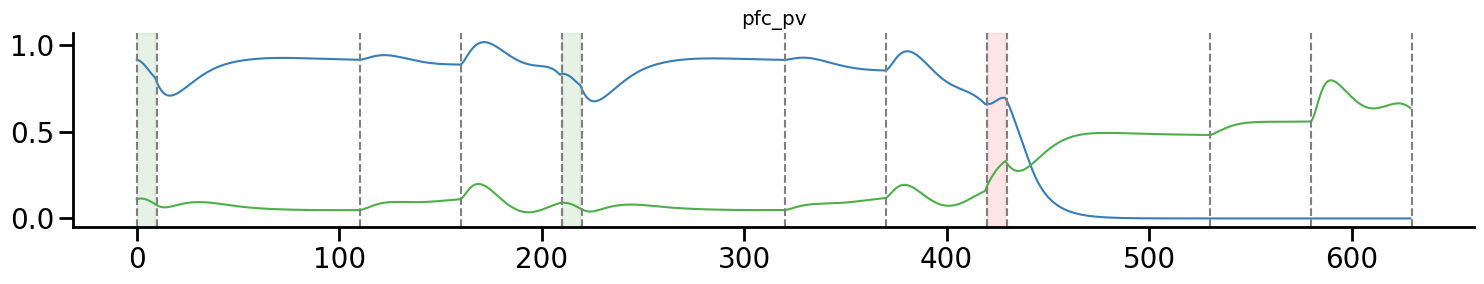

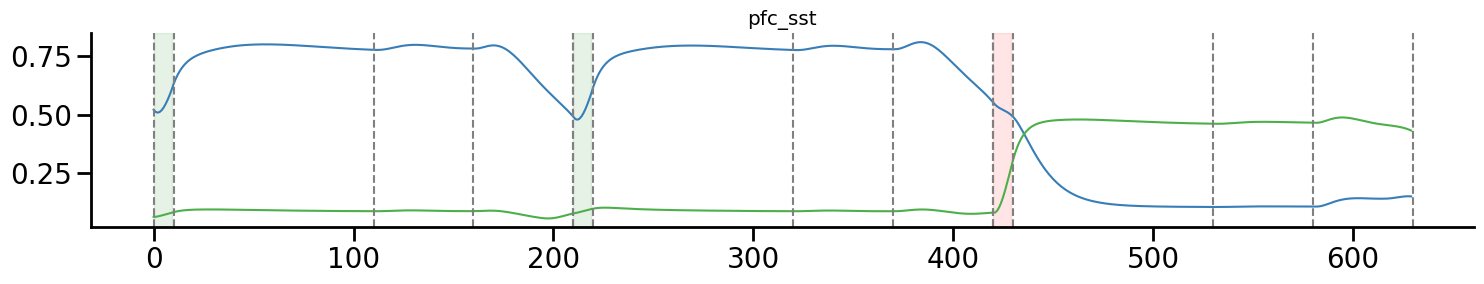

In [78]:
n_to_plot = 1    # number of neurons to plot for each group
colors = ['#377eb8', '#4daf4a', '#e41a1c']

data_suppfig1_single_cell_traces = dict.fromkeys(['sr_esoma', 'sr_pv', 'sr_sst', 'sr_vip', 'pfc_esoma', 'pfc_pv', 'pfc_sst'])
for key in data_suppfig1_single_cell_traces.keys():
    data_suppfig1_single_cell_traces[key] = []


for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
        if model_name != 'success_2023-05-10-14-28-42_wcst_63_sparsity0':    # this is the example model shown in the paper
            continue
        
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
        
        # load data
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_noiseless_no_current_matrix'), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data']
        mean_perf = np.mean([_[0] for _ in test_data['perfs']])
        mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
        if mean_perf<0.8 or mean_perf_rule<0.8:
            print('low performing model ({}/{})'.format(mean_perf, mean_perf_rule))
            continue
        rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
        
        # generate trial labels
        trial_labels = label_trials_wcst(test_data=test_data)
        rule1_trs_stable = trial_labels['rule1_trs_stable']
        rule2_trs_stable = trial_labels['rule2_trs_stable']
        rule1_trs_after_error = trial_labels['rule1_trs_after_error']
        rule2_trs_after_error = trial_labels['rule2_trs_after_error']
        c1_trs_stable = trial_labels['c1_trs_stable']
        c2_trs_stable = trial_labels['c2_trs_stable']
        c3_trs_stable = trial_labels['c3_trs_stable']
        resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
        error_trials = trial_labels['error_trials']
        
        # compute cell selectivity
        all_sels = compute_sel_wcst(rnn_activity=rnn_activity, hp=hp_test, hp_task=hp_task_test, rules=test_data['rules'],
                                         rule1_trs_stable=trial_labels['rule1_trs_stable'], rule2_trs_stable=trial_labels['rule2_trs_stable'],
                                         rule1_trs_after_error = trial_labels['rule1_trs_after_error'], rule2_trs_after_error=trial_labels['rule2_trs_after_error'],
                                         resp_trs_stable = resp_trs_stable, trs_by_center_card=trial_labels['trs_by_center_card_stable'],
                                         stims=test_data['stims'], error_trials=trial_labels['error_trials'], trial_labels=trial_labels)
        resp_sel_normalized = all_sels['resp_normalized']
        rule_sel_normalized = all_sels['rule_normalized_activity']

        # subregions
        subcg_pfc_idx = define_subpop_pfc(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
                                          rule_sel=all_sels['rule_normalized_activity'], err_sel=all_sels['error_normalized'], 
                                          rule1_trs_stable=rule1_trs_stable, 
                                          rule2_trs_stable=rule2_trs_stable, 
                                          rule1_after_error_trs=rule1_trs_after_error,
                                          rule2_after_error_trs=rule2_trs_after_error,
                                          rule1_after_correct_trs = trial_labels['rule1_trs_after_correct'],
                                          rule2_after_correct_trs = trial_labels['rule2_trs_after_correct'],
                                          rule_threshold=0.5, err_threshold=0.5)
        subcg_sr_idx = define_subpop_sr_wcst(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
                                          rule_sel=all_sels['rule_normalized_activity'], resp_sel=all_sels['resp_normalized'], ref_card_sel=all_sels['ref_card_normalized'],
                                          rule1_trs_stable=rule1_trs_stable, 
                                          rule2_trs_stable=rule2_trs_stable, 
                                          rule_threshold=0, resp_threshold=0)
        for subcg in subcg_pfc_idx.keys():
            model.rnn.cg_idx['subcg_pfc_'+subcg] = subcg_pfc_idx[subcg]
        for subcg in subcg_sr_idx.keys():
            model.rnn.cg_idx['subcg_sr_'+subcg] = subcg_sr_idx[subcg]

            
            
        #======= PLOT ========#
        n_trials = rnn_activity.shape[0]
        rules = test_data['rules']
        switch_trs = [tr for tr in range(n_trials-1) if rules[tr]=='color' and rules[tr+1]=='shape']
        first_tr = switch_trs[0]
        trs_to_plot = [first_tr, first_tr+1, first_tr+2]
        # for tr in trs_to_plot:
        #     print(rules[tr])
        rnn_activity_selected = rnn_activity[trs_to_plot, :, 0, :]
        n_ts = rnn_activity.shape[1]
        n_units = rnn_activity.shape[-1]
        rnn_activity_selected = rnn_activity_selected.reshape(3*n_ts, n_units)   

        abs_rule_sel_sorted = {k: v for k, v in sorted(all_sels['rule_activity'].items(), key=lambda item: np.abs(item[1]), reverse=True)}    # sort the units according to the firing rate difference during the two rules. pick the top ones for plotting

        units_to_plot_across_cgs = {}
        for cg in model.rnn.cell_group_list:
            if 'dend' in cg or cg=='pfc_vip':
                # print('do not plot dendrite or pfc_vip')
                continue
            if 'sr' in cg:
                subcg_idx = subcg_sr_idx
            elif 'pfc' in cg:
                subcg_idx = subcg_pfc_idx
            if len(subcg_idx['rule1_{}'.format(cg)])==0 or len(subcg_idx['rule2_{}'.format(cg)])==0:
                print('No rule 1/2 neurons')
                break
            else:
                units_to_plot_rule1 = [n for n in abs_rule_sel_sorted.keys() if n in subcg_idx['rule1_{}'.format(cg)]][:n_to_plot]   
                units_to_plot_rule2 = [n for n in abs_rule_sel_sorted.keys() if n in subcg_idx['rule2_{}'.format(cg)]][:n_to_plot] 
                # print('rule selectivity for the units to plot for rule 1: {}'.format([all_sels['rule_activity'][n] for n in units_to_plot_rule1]))
                # print('rule selectivity for the units to plot for rule 2: {}'.format([all_sels['rule_activity'][n] for n in units_to_plot_rule2]))
                # if np.abs(np.mean([all_sels['rule_activity'][n] for n in units_to_plot_rule1])) < 0.00 or np.abs(np.mean([all_sels['rule_activity'][n] for n in units_to_plot_rule2])) < 0.00:
                #     print('firing rate difference is too small')
                #     break    # firing rate difference is too small
                units_to_plot = units_to_plot_rule1 + units_to_plot_rule2
                if cg == 'pfc_esoma':
                    if len(subcg_pfc_idx['mix_err_rule2_{}'.format(cg)]) == 0:
                        print('no error x shape neuron, pass')
                        break
                    units_to_plot_mixerr = list(np.random.choice(subcg_pfc_idx['mix_err_rule2_{}'.format(cg)], n_to_plot, replace=False))
                    units_to_plot += units_to_plot_mixerr
            units_to_plot_across_cgs[cg] = units_to_plot
            

        if len(list(units_to_plot_across_cgs.keys())) == 7:    # when all the cgs in the model have some good example units (except for PFC VIP)
            for cg in units_to_plot_across_cgs.keys():
                units_to_plot = units_to_plot_across_cgs[cg]
                fig, ax = plt.subplots(figsize=[15, 3])
                ax.set_title(cg)
                for i in range(len(units_to_plot)):
                    n = units_to_plot[i]
                    if 'sr' in cg:
                        if n in subcg_sr_idx['rule1_{}'.format(cg)]:
                            color = colors[0]
                        elif n in subcg_sr_idx['rule2_{}'.format(cg)]:
                            color = colors[1]
                    elif 'pfc' in cg:
                        if n in subcg_pfc_idx['rule1_{}'.format(cg)]:
                            color = colors[0]
                        elif n in subcg_pfc_idx['rule2_{}'.format(cg)]:
                            color = colors[1]
                        else:
                            color = colors[2]
                    ax.plot(rnn_activity_selected[:, n], color=color)
                    data_suppfig1_single_cell_traces[cg].append(rnn_activity_selected[:, n])
                ax.axvspan(int(hp_task_test['trial_history_start']/hp_test['dt']), int(hp_task_test['trial_history_end']/hp_test['dt'])-1, color='green', alpha=0.1) 
                ax.axvspan(int(hp_task_test['trial_history_start']/hp_test['dt'])+n_ts, int(hp_task_test['trial_history_end']/hp_test['dt'])-1+n_ts, color='green', alpha=0.1) 
                ax.axvspan(int(hp_task_test['trial_history_start']/hp_test['dt'])+2*n_ts, int(hp_task_test['trial_history_end']/hp_test['dt'])-1+2*n_ts, color='red', alpha=0.1) 
                for i in range(3):
                    ax.axvline(x=hp_task_test['trial_history_start']//hp_test['dt'] + i*n_ts, linestyle='dashed', color='gray')
                    ax.axvline(x=hp_task_test['trial_history_end']//hp_test['dt'] + i*n_ts, linestyle='dashed', color='gray')
                    ax.axvline(x=hp_task_test['center_card_on']//hp_test['dt'] + i*n_ts, linestyle='dashed', color='gray')
                    ax.axvline(x=hp_task_test['test_cards_on']//hp_test['dt'] + i*n_ts, linestyle='dashed', color='gray')
                    ax.axvline(x=hp_task_test['resp_end']//hp_test['dt'] + i*n_ts, linestyle='dashed', color='gray')
                make_pretty_axes(ax)
                fig.tight_layout()
                plt.show()
                fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/single_cell_traces_{}.pdf'.format(cg))

for key in data_suppfig1_single_cell_traces.keys():
    data_suppfig1_single_cell_traces[key] = np.array(data_suppfig1_single_cell_traces[key])
    pd.DataFrame(data_suppfig1_single_cell_traces[key]).to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig1_single_cell_traces_{}.csv'.format(key))
